In [1]:
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
def experiments(replace,date,var1,var2):
    ### Original data
    data = pd.read_csv(path+'Data_to_train.csv', parse_dates = True, index_col = 0)
    dat_p = data.loc['2017-03-15':'2017-05-15']
    dat = dat_p
    ### Lets try to produce only reversals and only organise convection
    apr12 = dat_p.loc[date]
    ### Change the advection of moisture completely
    if var1 == None and var2 == None:
        for i in replace:
            dat[i] = apr12[i]
    elif var2 == None:
        for i in replace:
            dat[i] = apr12[var1]
    else:
        count = 0
        for i in replace:
            if count < 7: 
                dat[i] = apr12[var1]
                count = count + 1
            else:
                dat[i] = apr12[var2]
                count = count + 1
    ### Prediction
    Xvals = dat[0:int(len(dat)*1)][['SST','IQR','TCWV','LW','W0','W1','W7','U0','U1','U4','U7','U11','U14','U26',
                                    'V0','V1','V4','V7','V9','V12','V14','V26']].values
    predic = NN_model.predict(Xvals) 
    return(predic)

# Now we have the data ready!

In [45]:
###Read Datasets and convert them!
#Path
latitud = '2-9'
longitud = '135-145'
path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
#Data
Y = pd.read_csv(path+'Slopes_data_ERA5.csv')
X = pd.read_csv(path+'Data_to_train.csv')
X = X[X.columns[1:]]
Y = pd.DataFrame({'Slope':np.array(Y['Slope'])})

# Training!

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.2)
#X_train = X[:int(len(X)*0.8)]; X_test = X[int(len(X)*0.8):]; y_train = Y[:int(len(Y)*0.8)]
#y_test = Y[int(len(Y)*0.8):]
#X_train = X[0:int(len(X)*1)][['SST','TCWV','LW','W0','W1','W7','U0','U1','U4','U7','U11','U14','U26','V0','V1',
#                              'V4','V7','V9','V12','V14','V26']].values
#y_train = Y[0:int(len(Y)*1)][['Slope']].values

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
### Random Forest
NN_model = RandomForestRegressor()
NN_model.fit(X_train, y_train)
#
### Neural Network
#
#nn = 64
#NN_model = MLPRegressor(hidden_layer_sizes=(nn,nn,nn,nn,nn),activation="relu")
#NN_model.fit(X_train, y_train)
##
### Decision Tree
#
#NN_model = DecisionTreeRegressor()
#NN_model.fit(X_train, y_train)
##
### SVM
#
#NN_model = SVR(kernel='rbf', C = 10**5, gamma = 0.1)
#NN_model.fit(X_train, y_train)

<ipython-input-103-e45e9a1cfc70>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  NN_model.fit(X_train, y_train)


RandomForestRegressor()

## Training test

In [104]:
from sklearn.metrics import r2_score,mean_squared_error
Pred_test = NN_model.predict(X_test) 
r2skill=r2_score(y_test, Pred_test)
bias=np.mean(Pred_test)-np.mean(y_test)
rmse=np.sqrt(mean_squared_error(y_test, Pred_test))
r = np.corrcoef(y_test['Slope'], Pred_test)
print("r2",r2skill,"bias",bias,"RMSE", rmse, 'r', r[0,1])

r2 0.9666763026428163 bias Slope    0.000028
dtype: float64 RMSE 0.0008147564867451568 r 0.9866757415862384


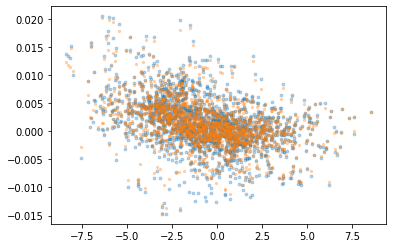

In [105]:
plt.scatter(X_test['V26'][0:2000],y_test['Slope'][0:2000],s=8,alpha=0.3,label="Observations")
plt.scatter(X_test['V26'][0:2000],Pred_test[0:2000],s=5,alpha=0.3,label="Model")

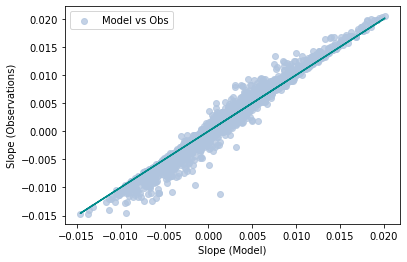

In [106]:
plt.scatter(Pred_test,y_test, color = 'lightsteelblue', alpha = 0.75, label = 'Model vs Obs')
plt.plot(Pred_test,Pred_test, color = 'darkcyan')
plt.ylabel('Slope (Observations)')
plt.xlabel('Slope (Model)')
plt.legend()

# Prediction!

In [107]:
### Where is the test case? 2017-03-15 to 2017-05-15
slope = pd.read_csv(path+'Slopes_data_'+latitud+'_'+longitud+'_ERA5.csv', parse_dates = True, index_col = 0)
data = pd.read_csv(path+'Data_to_train.csv', parse_dates = True, index_col = 0)
dates = [d.strftime('%Y-%m-%d') for d in pd.date_range('2017-03-15','2017-05-10', freq='5d')]
dat_p = data.loc['2017-03-15':'2017-05-15']
slo_p = slope.loc['2017-03-15':'2017-05-15']
Xvals = dat_p[0:int(len(dat_p)*1)][['SST','IQR','TCWV','LW','W0','W1','W7','U0','U1','U4','U7','U11','U14','U26',
                                    'V0','V1','V4','V7','V9','V12','V14','V26']].values
pred = NN_model.predict(Xvals) 

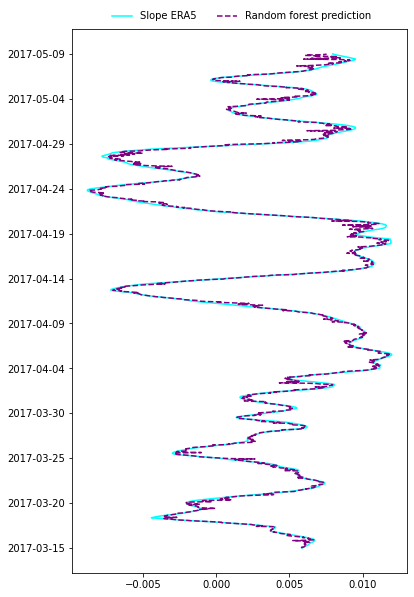

In [108]:
plt.figure(figsize = (6,10))
plt.plot(slo_p['Slope'][0:55*24].values,np.linspace(0,55,len(pred[0:55*24])), label = 'Slope ERA5', color = 'cyan')
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Random forest prediction', color = 'purple', linestyle = '--')
plt.legend(frameon=False, bbox_to_anchor = (0.92,1.05), ncol=2)
plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
plt.show()

# Experiments!

In [75]:
###
# Moisture advection
# Moisture structures
# Total wind
# Zonal wind
# Meridional wind
# No-Meridional shear
# No-Zonal shear
# No shear
# No-Meridional low troposphere shear
# No-Meridional mid and high troposphere shear
# No-Zonal low troposphere shear
# No-Zonal mid and high troposphere shear

In [113]:
### Remember that level 26 is the surface and level 0 is the heighest one!
replaces = [
            ['TCWV','U0','U1','U4','U7','U11','U14','U26','V0','V1','V4','V7','V9','V12','V14','V26'],
            ['IQR','TCWV','V26'],
            ['U0','U1','U4','U7','U11','U14','U26','V0','V1','V4','V7','V9','V12','V14','V26'],
            ['U0','U1','U4','U7','U11','U14','U26'], 
            ['V0','V1','V4','V7','V9','V12','V14','V26'], 
            ['V0','V1','V4','V7','V9','V12','V14','V26'],
            ['U0','U1','U4','U7','U11','U14','U26'],
            ['U0','U1','U4','U7','U11','U14','U26','V0','V1','V4','V7','V9','V12','V14','V26'],
            ['V12','V14','V26'],
            ['V0','V1','V4','V7','V9'],
            ['U11','U14','U26'], 
            ['U0','U1','U4','U7']
            ]
april_12 = np.ones((55*24,len(replaces)))
march_20 = np.ones((55*24,len(replaces)))
var1 = [None,None,None,None,None,'V26','U26','U26','V26','V9','U26','U7']
var2 = [None,None,None,None,None,None,None,'V26',None,None,None,None]
for i,replace in enumerate(replaces):
        april_12[:,i] = experiments(replace,'2017-04-12 16:00:00',var1[i],var2[i])[0:55*24]
        march_20[:,i] = experiments(replace,'2017-04-05 06:00:00',var1[i],var2[i])[0:55*24]
    #'2017-04-05 06:00:00' this date works also to produce organization
    #'2017-03-21 12:00:00' 

<ipython-input-79-0fb3abf272be>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[i] = apr12[i]
<ipython-input-79-0fb3abf272be>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[i] = apr12[i]
<ipython-input-79-0fb3abf272be>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

<ipython-input-79-0fb3abf272be>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[i] = apr12[var1]
<ipython-input-79-0fb3abf272be>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[i] = apr12[var1]


### Lets plot them all

In [114]:
from matplotlib.gridspec import GridSpec
from pylab import *

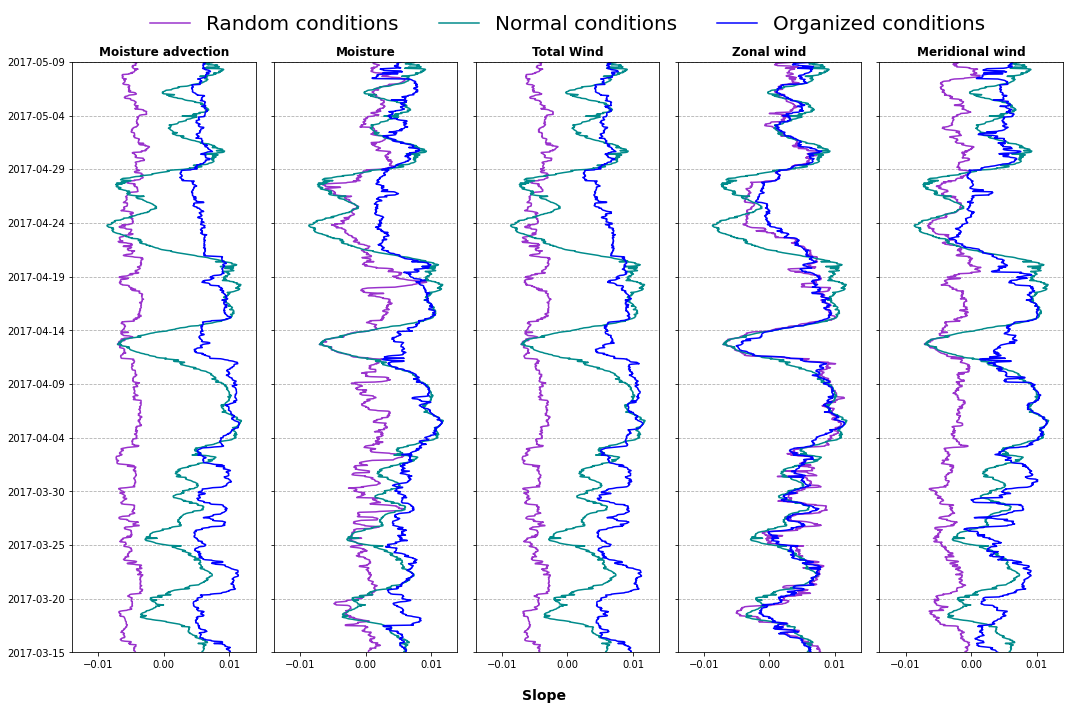

In [115]:
fig = plt.figure(figsize=(16,10))
gs = GridSpec(1,5,left = 0.09, right = 0.95, hspace=0, wspace=0.1, top = 0.9, bottom = 0.08)
title = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind']

for i in range(5):
    ax = plt.subplot(gs[i])
    plt.plot(april_12[:,i],np.linspace(0,55,len(april_12[:,i])), label = 'Random conditions', color = 'darkorchid')
    plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'darkcyan')
    plt.plot(march_20[:,i],np.linspace(0,55,len(march_20[:,i])), label = 'Organized conditions', color = 'blue')
    plt.title(title[i], fontweight = 'bold')
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    fig.supxlabel('Slope', fontweight = 'bold', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    if i == 0:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    else:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55])
        ax.yaxis.set_major_formatter(NullFormatter())
    if i == 2:
        plt.legend(ncol=3, frameon=False, bbox_to_anchor=(0.5,1.11), fontsize = 20, loc='upper center') #0.5,1.09
plt.savefig(path+'Exp_moist_wind.jpg', bbox_inches='tight')

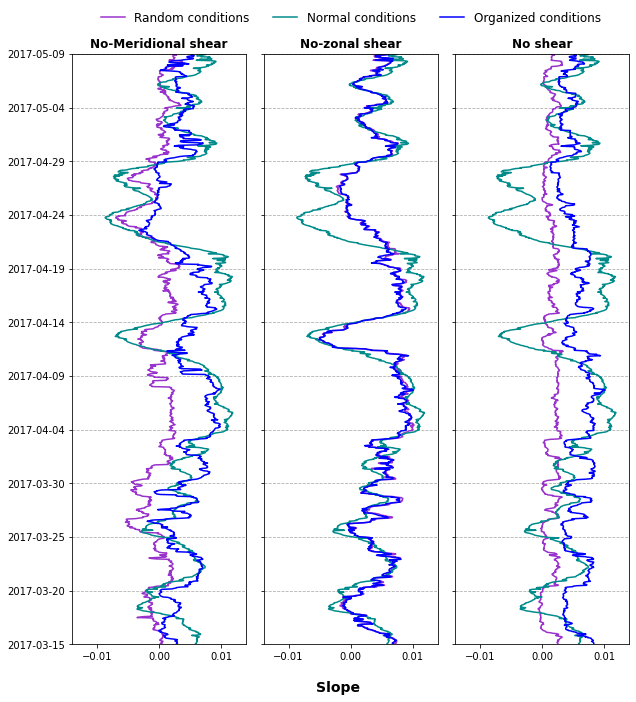

In [116]:
fig = plt.figure(figsize=(9,10))
gs = GridSpec(1,3,left = 0.09, right = 0.95, hspace=0, wspace=0.1, top = 0.9, bottom = 0.08)
titles = ['No-Meridional shear', 'No-zonal shear', 'No shear']

for i,title in enumerate(titles):
    ax = plt.subplot(gs[i])
    plt.plot(april_12[:,i+5],np.linspace(0,55,len(april_12[:,i+5])), label = 'Random conditions', 
             color = 'darkorchid')
    plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'darkcyan')
    plt.plot(march_20[:,i+5],np.linspace(0,55,len(march_20[:,i+5])), label = 'Organized conditions', 
             color = 'blue')
    plt.title(title, fontweight = 'bold')
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    fig.supxlabel('Slope', fontweight = 'bold', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    if i == 0:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    else:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55])
        ax.yaxis.set_major_formatter(NullFormatter())
    if i == 1:
        plt.legend(ncol=3, frameon=False, bbox_to_anchor=(0.5,1.09), fontsize = 12, loc='upper center')
plt.savefig(path+'Exp_shear.jpg', bbox_inches='tight')

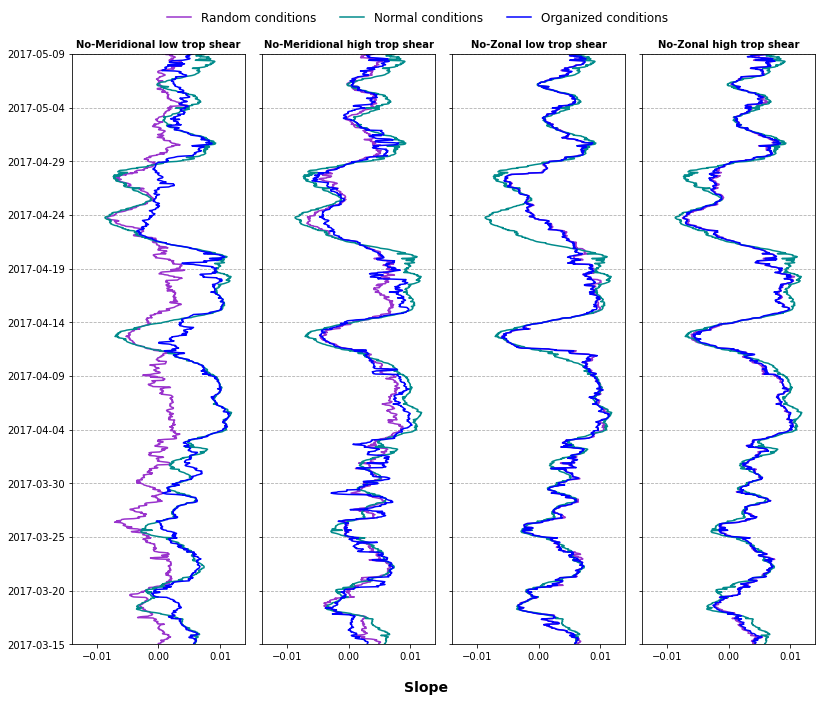

In [117]:
fig = plt.figure(figsize=(12,10))
gs = GridSpec(1,4,left = 0.09, right = 0.95, hspace=0, wspace=0.1, top = 0.9, bottom = 0.08)
titles = ['No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']

for i,title in enumerate(titles):
    ax = plt.subplot(gs[i])
    plt.plot(april_12[:,i+8],np.linspace(0,55,len(april_12[:,i+8])), label = 'Random conditions', 
             color = 'darkorchid')
    plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'darkcyan')
    plt.plot(march_20[:,i+8],np.linspace(0,55,len(march_20[:,i+8])), label = 'Organized conditions', 
             color = 'blue')
    plt.title(title, fontweight = 'bold', fontsize = 10)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    fig.supxlabel('Slope', fontweight = 'bold', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    if i == 0:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    else:
        plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55])
        ax.yaxis.set_major_formatter(NullFormatter())
    if i == 1:
        plt.legend(ncol=3, frameon=False, bbox_to_anchor=(0.9,1.09), fontsize = 12, loc='upper center')
plt.savefig(path+'Exp_shear_2.jpg', bbox_inches='tight')

# Now two questions to answer
## Why the reversals happen
## Why the convection is organized

### Experiments for reversals first!

In [118]:
data = pd.read_csv(path+'Data_to_train.csv', parse_dates = True, index_col = 0)
dat_p = data.loc['2017-03-15':'2017-05-15']
dat = dat_p
### Lets try to produce only reversals and only organise convection
apr12 = dat_p.loc['2017-04-12 16:00:00']
mar20 = dat_p.loc['2017-04-05 06:00:00']

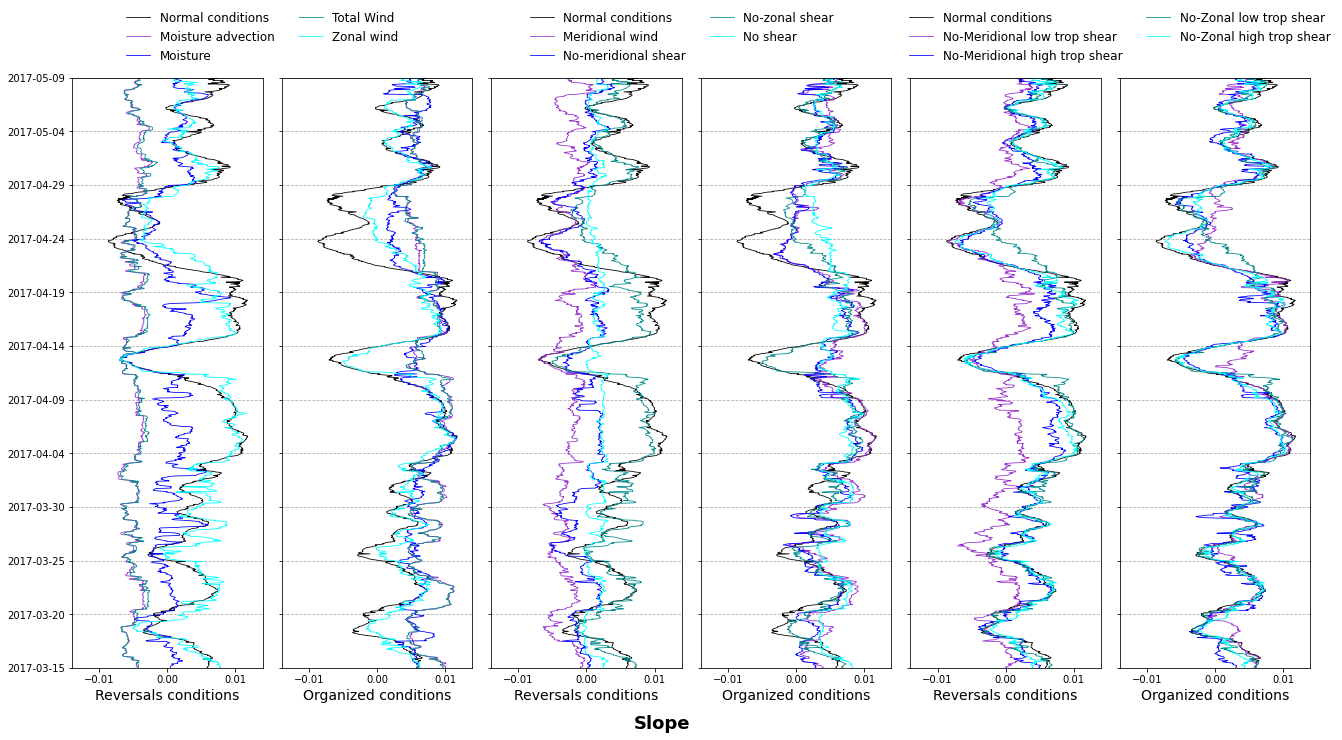

In [119]:
fig = plt.figure(figsize=(20,10))
c = ['darkorchid','blue','darkcyan','cyan','red']
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']

gs = GridSpec(1,6,left = 0.09, right = 0.95, hspace=0.1, wspace=0.1, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
fig.supxlabel('Slope', fontweight = 'bold', fontsize = 18, y = -0.01)
for i in range(4):
    plt.plot(april_12[:,i],np.linspace(0,55,len(april_12[:,i])), label = labels[i], color = c[i], 
             linewidth = 0.8)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Reversals conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    plt.legend(ncol=2, frameon=False, bbox_to_anchor=(1.0,1.13), fontsize = 12, loc='upper center')

ax = plt.subplot(gs[1])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
for i in range(4):
    plt.plot(march_20[:,i],np.linspace(0,55,len(march_20[:,i])), label = labels[i], color = c[i], 
             linewidth = 0.8)    
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Organized conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    ax.yaxis.set_major_formatter(NullFormatter())

#c = ['green','red','orange','grey']
ax = plt.subplot(gs[2])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
for i in range(4):
    plt.plot(april_12[:,i+4],np.linspace(0,55,len(april_12[:,i+4])), label = labels[i+4], color = c[i], 
             linewidth = 0.8)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Reversals conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.legend(ncol=2, frameon=False, bbox_to_anchor=(1.0,1.13), fontsize = 12, loc='upper center')
    
ax = plt.subplot(gs[3])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
for i in range(4):
    plt.plot(march_20[:,i+4],np.linspace(0,55,len(march_20[:,i+4])), label = labels[i+4], color = c[i], 
             linewidth = 0.8)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Organized conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    ax.yaxis.set_major_formatter(NullFormatter())
    
ax = plt.subplot(gs[4])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
for i in range(4):
    plt.plot(april_12[:,i+8],np.linspace(0,55,len(april_12[:,i+8])), label = labels[i+8], color = c[i], 
             linewidth = 0.8)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Reversals conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.legend(ncol=2, frameon=False, bbox_to_anchor=(1.1,1.13), fontsize = 12, loc='upper center')
    
ax = plt.subplot(gs[5])
plt.plot(pred[0:55*24],np.linspace(0,55,len(pred[0:55*24])), label = 'Normal conditions', color = 'k',
         linewidth = 0.8)
for i in range(4):
    plt.plot(march_20[:,i+8],np.linspace(0,55,len(march_20[:,i+8])), label = labels[i+8], color = c[i], 
             linewidth = 0.8)
    plt.grid(linestyle='--', linewidth = 0.8, axis = 'y')
    plt.xlabel('Organized conditions', fontsize = 14)
    plt.xticks(np.arange(-0.01,0.011,0.01))
    plt.xlim(-0.014,0.014)
    plt.ylim(0,55)
    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55], labels = dates)
    ax.yaxis.set_major_formatter(NullFormatter())


# This is a type of index!

(0.0, 5.5)

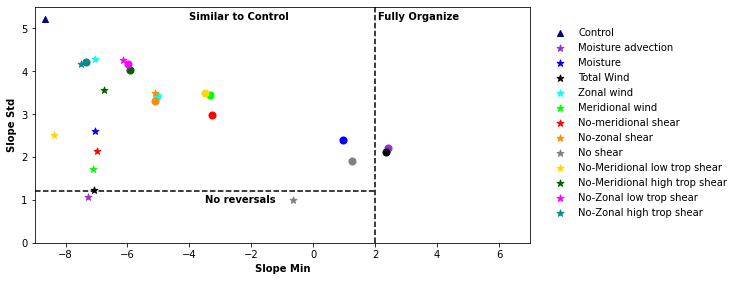

In [120]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_max = np.min(april_12[:,:], axis = 0)*1000
mar_max = np.min(march_20[:,:], axis = 0)*1000
apr_std = np.std(april_12[:,:], axis = 0)*1000
mar_std = np.std(march_20[:,:], axis = 0)*1000

plt.figure(figsize=(8,4))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.min(pred[0:55*24])*1000,(np.std(pred[0:55*24])*1000), marker = '^', color = 'darkblue', 
            label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_max[i], apr_std[i], color = c[i], label = x, marker = '*', s = 50)
    plt.scatter(mar_max[i], mar_std[i], color = c[i], s = 50)#, label = x)

plt.legend(bbox_to_anchor=(1.22,0.95), ncol=1, frameon=False, loc='upper center')
plt.plot(np.arange(-9,2.1),np.ones(12)*1.2, linestyle='--', color = 'k')
plt.text(-3.5,0.95,'No reversals', fontweight = 'bold')
plt.axvline(2, linestyle='--', color = 'k')
plt.text(2.1,5.2,'Fully Organize', fontweight = 'bold')
plt.text(-4,5.2,'Similar to Control', fontweight = 'bold')
plt.xlabel('Slope Min', fontweight = 'bold')
plt.ylabel('Slope Std', fontweight = 'bold')
plt.xlim(-9,7)
plt.ylim(0,5.5)

In [121]:
import scipy.stats as stats
spea_20 = []
spea_12 = []
for i in range(len(labels)):
    z = stats.pearsonr(april_12[:,i],pred[0:55*24])[0]
    spea_12.append(z)
    z = stats.pearsonr(march_20[:,i],pred[0:55*24])[0]
    spea_20.append(z)

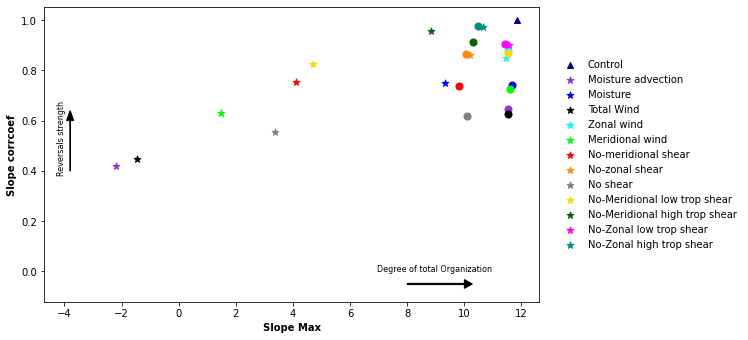

In [122]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_max = np.max(april_12[:,:], axis = 0)*1000
mar_max = np.max(march_20[:,:], axis = 0)*1000

apr_cor = spea_12
mar_cor = spea_20

plt.figure(figsize=(8,5))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.max(pred[0:55*24])*1000,1, marker = '^', color = 'darkblue', 
            label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_max[i], apr_cor[i], color = c[i], label = x, marker = '*', s = 50)
    plt.scatter(mar_max[i], mar_cor[i], color = c[i], s = 50)#, label = 'Random '+x)

plt.legend(bbox_to_anchor=(1.22,0.85), ncol=1, frameon=False, loc='upper center')
plt.arrow(-3.8,0.4,0,0.2, width=0.02, head_width = 0.25, head_length = 0.04, color = 'k')
plt.text(-4.25,0.39,'Reversals strength', rotation = 90, fontsize = 8)
plt.arrow(8,-0.05,2,0, width=0.005, head_width = 0.035, head_length = 0.28, color = 'k')
plt.text(6.95,0.0,'Degree of total Organization', fontsize = 8)
plt.xlabel('Slope Max', fontweight = 'bold')
plt.ylabel('Slope corrcoef', fontweight = 'bold')
#plt.xlim(-9,7)
plt.show()


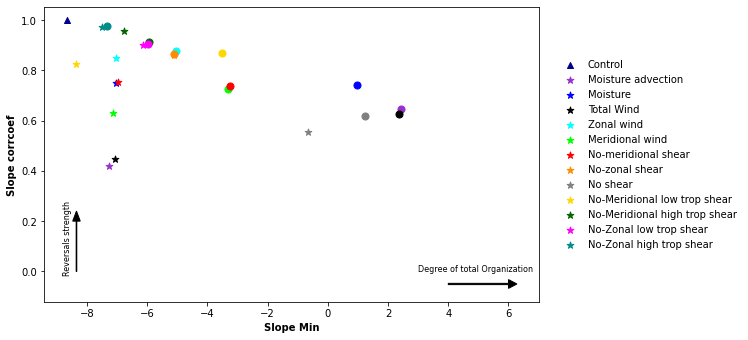

In [123]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_min = np.min(april_12[:,:], axis = 0)*1000
mar_min = np.min(march_20[:,:], axis = 0)*1000

apr_cor = spea_12
mar_cor = spea_20

plt.figure(figsize=(8,5))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.min(pred[0:55*24])*1000,1, marker = '^', color = 'darkblue', 
            label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_min[i], apr_cor[i], color = c[i], label = x, marker = '*', s = 50)
    plt.scatter(mar_min[i], mar_cor[i], color = c[i], s = 50)#, label = 'Random '+x)

plt.legend(bbox_to_anchor=(1.22,0.85), ncol=1, frameon=False, loc='upper center')
plt.arrow(-8.35,0,0,0.2, width=0.02, head_width = 0.25, head_length = 0.04, color = 'k')
plt.text(-8.8,-0.008,'Reversals strength', rotation = 90, fontsize = 8)
plt.arrow(4,-0.05,2,0, width=0.005, head_width = 0.035, head_length = 0.28, color = 'k')
plt.text(3,0.0,'Degree of total Organization', fontsize = 8)
plt.xlabel('Slope Min', fontweight = 'bold')
plt.ylabel('Slope corrcoef', fontweight = 'bold')
#plt.xlim(-9,7)
plt.show()

In [124]:
iqr_20 = []
iqr_12 = []
quas = 95
quae = 5
for i in range(len(labels)):
    iqr_12.append(np.percentile(april_12[:,i],quas) - np.percentile(april_12[:,i],quae))
    iqr_20.append(np.percentile(march_20[:,i],quas) - np.percentile(march_20[:,i],quae))

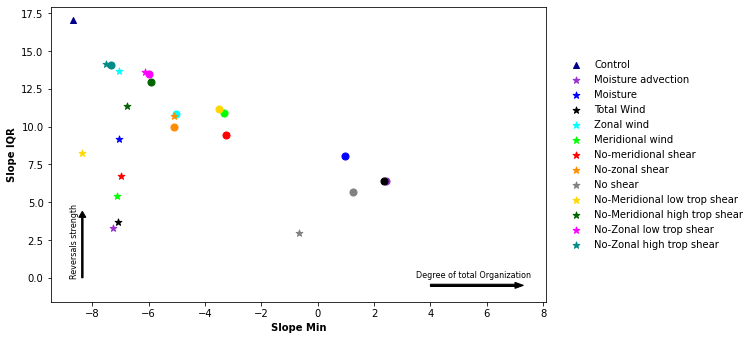

In [125]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_min = np.min(april_12[:,:], axis = 0)*1000
mar_min = np.min(march_20[:,:], axis = 0)*1000

apr_iqr = iqr_12
mar_iqr = iqr_20

plt.figure(figsize=(8,5))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.min(pred[0:55*24])*1000,(np.percentile(pred[0:55*24],quas)-np.percentile(pred[0:55*24],quae))*1000,
            marker = '^', color = 'darkblue', label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_min[i], apr_iqr[i]*1000, color = c[i], label = x, marker = '*', s = 50)
    plt.scatter(mar_min[i], mar_iqr[i]*1000, color = c[i], s = 50)#, label = 'Random '+x)

plt.legend(bbox_to_anchor=(1.22,0.85), ncol=1, frameon=False, loc='upper center')
plt.arrow(-8.35,0,0,4, width=0.05, head_width = 0.25, head_length = 0.4, color = 'k')
plt.text(-8.8,0.12,'Reversals strength', rotation = 90, fontsize = 8)
plt.arrow(4,-0.5,3,0, width=0.15, head_width = 0.4, head_length = 0.3, color = 'k')
plt.text(3.5,0,'Degree of total Organization', fontsize = 8)
plt.xlabel('Slope Min', fontweight = 'bold')
plt.ylabel('Slope IQR', fontweight = 'bold')
#plt.xlim(-9,7)
plt.show()

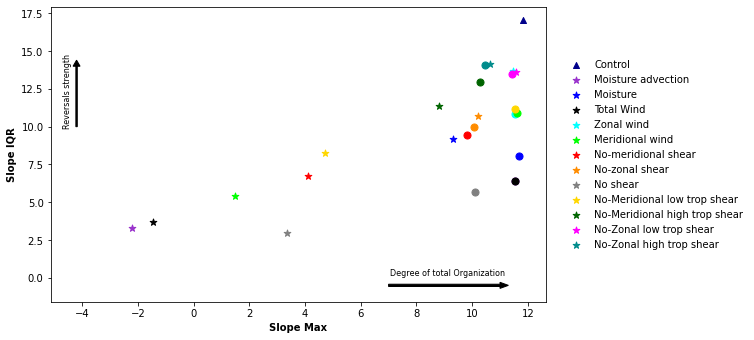

In [126]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_max = np.max(april_12[:,:], axis = 0)*1000
mar_max = np.max(march_20[:,:], axis = 0)*1000

apr_iqr = iqr_12
mar_iqr = iqr_20

plt.figure(figsize=(8,5))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.max(pred[0:55*24])*1000,(np.percentile(pred[0:55*24],quas)-np.percentile(pred[0:55*24],quae))*1000,
            marker = '^', color = 'darkblue', label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_max[i], apr_iqr[i]*1000, color = c[i], label = x, marker = '*', s = 50)
    plt.scatter(mar_max[i], mar_iqr[i]*1000, color = c[i], s = 50)

plt.legend(bbox_to_anchor=(1.22,0.85), ncol=1, frameon=False, loc='upper center')
plt.arrow(-4.2,10,0,4, width=0.05, head_width = 0.25, head_length = 0.4, color = 'k')
plt.text(-4.7,10.05,'Reversals strength', rotation = 90, fontsize = 8)
plt.arrow(7,-0.5,4,0, width=0.15, head_width = 0.4, head_length = 0.3, color = 'k')
plt.text(7.05,0.15,'Degree of total Organization', fontsize = 8)
plt.xlabel('Slope Max', fontweight = 'bold')
plt.ylabel('Slope IQR', fontweight = 'bold')
#plt.xlim(-9,7)
plt.show()

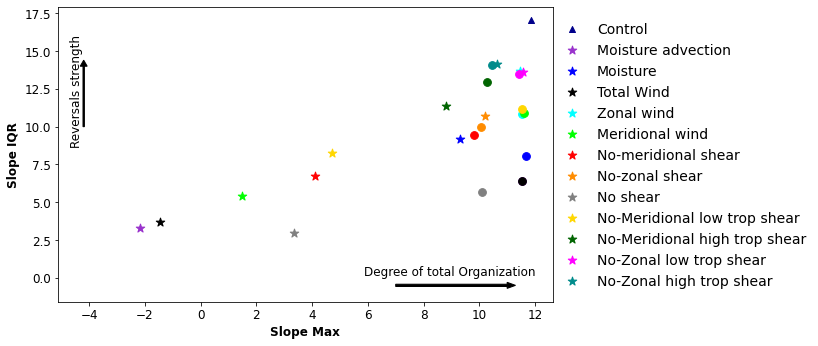

In [127]:
### First experiments
labels = ['Moisture advection','Moisture','Total Wind','Zonal wind','Meridional wind','No-meridional shear',
          'No-zonal shear', 'No shear','No-Meridional low trop shear', 'No-Meridional high trop shear', 
          'No-Zonal low trop shear', 'No-Zonal high trop shear']
c = ['darkorchid','blue','k','cyan','lime','red','darkorange','grey','gold','darkgreen','magenta','darkcyan']

apr_max = np.max(april_12[:,:], axis = 0)*1000
mar_max = np.max(march_20[:,:], axis = 0)*1000

apr_iqr = iqr_12
mar_iqr = iqr_20

plt.figure(figsize=(8,5))
gs = GridSpec(1,1,left = 0.09, right = 0.95, hspace=0.2, wspace=0, top = 0.9, bottom = 0.08)
ax = plt.subplot(gs[0])

plt.scatter(np.max(pred[0:55*24])*1000,(np.percentile(pred[0:55*24],quas)-np.percentile(pred[0:55*24],quae))*1000,
            marker = '^', color = 'darkblue', label = 'Control')
for i,x in enumerate(labels):
    plt.scatter(apr_max[i], apr_iqr[i]*1000, color = c[i], label = x, marker = '*', s = 80)
    plt.scatter(mar_max[i], mar_iqr[i]*1000, color = c[i], s = 60)

plt.legend(bbox_to_anchor=(1.26,0.99), ncol=1, frameon=False, loc='upper center', fontsize = 14)
plt.arrow(-4.2,10,0,4, width=0.05, head_width = 0.25, head_length = 0.4, color = 'k')
plt.text(-4.7,8.8,'Reversals strength', rotation = 90, fontsize = 12)
plt.arrow(7,-0.5,4,0, width=0.15, head_width = 0.4, head_length = 0.3, color = 'k')
plt.text(5.85,0.15,'Degree of total Organization', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Slope Max', fontweight = 'bold', fontsize = 12)
plt.ylabel('Slope IQR', fontweight = 'bold', fontsize = 12)
#plt.xlim(-9,7)
plt.show()